In [19]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce
%matplotlib inline

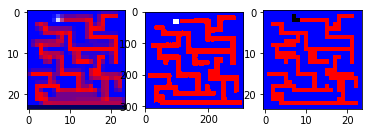

In [114]:
img = plt.imread('maze.jpg')

#img = rescale(img, 1/32.0)
img = downscale_local_mean(img, (10,10,1)) /255.0
plt.subplot(131)
plt.imshow(img)

img = np.pad(img,((3,1),(3,1),(0,0)),mode='constant',constant_values=0)
for y in xrange(img.shape[0]):
    for x in xrange(img.shape[1]):
        if img[y,x,:].sum() == 0:
            img[y,x,:] = [0,0,1]
        if img[y,x,:].max() - img[y,x,:].min() < 0.4:
            img[y,x,:] = [0,0,1]
        if img[y,x,0] == img[y,x,:].max():
            img[y,x,:] = [1,0,0]
        if img[y,x,2] == img[y,x,:].max():
            img[y,x,:] = [0,0,1]
        if img[y,x,1] == img[y,x,:].max():
            img[y,x,:] = [1,1,1]
plt.subplot(132)
plt.imshow(img)
maze_viz = img.copy()
maze_viz = block_reduce(maze_viz,(13,13,1),np.mean)
plt.subplot(131)
plt.imshow(maze_viz)

for y in xrange(maze_viz.shape[0]):
    for x in xrange(maze_viz.shape[1]):
        if maze_viz[y,x,:].sum() > 1.5:
            maze_viz[y,x,:] = [0,0,0]
        elif maze_viz[y,x,0] > 0.55:
            maze_viz[y,x,:] = [1,0,0]
        else:
            maze_viz[y,x,:] = [0,0,1]
img = maze_viz
plt.subplot(133)
plt.imshow(maze_viz)

#maze_size = 10
#maze_px = 1
#start = (0,0)
#end = (5,5)
#img = img[:,:,[2,1,0]]
#maze_viz = img.copy()
#for y in xrange(end[0]*maze_px,(end[0]+1)*(maze_px)):
#    for x in xrange(end[1]*maze_px,(end[1]+1)*(maze_px)):
#        maze_viz[y,x,:] = 0.0
#plt.imshow(maze_viz,interpolation='nearest')

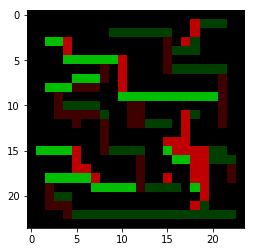

In [115]:
up = (0.75,0,0)
down = (0.25,0,0.0)
left = (0.0,0.75,0)
right = (0.0,0.25,0)

sol = np.zeros_like(img)
dist = np.zeros_like(img)

visited = np.zeros_like(img)
visited[maze_viz[:,:,2] > 0.5] = 1

queue = []
for y in xrange(img.shape[0]):
    for x in xrange(img.shape[1]):
        if maze_viz[y,x,:].sum() == 0:
            queue.append([y,x,0,0])
            visited[y,x,:] = 1
steps = 0
while len(queue) > 0:
    y,x,c,s = queue.pop(0)
    if y+1 < img.shape[0] and visited[y+1,x,0] < 1:
        queue.append([y+1,x,down,s+1])
    if x+1 < img.shape[1] and visited[y,x+1,0] < 1:
        queue.append([y,x+1,right,s+1])
    if y-1 >= 0 and visited[y-1,x,0] < 1:
        queue.append([y-1,x,up,s+1])
    if x-1 >= 0 and visited[y,x-1,0] < 1:
        queue.append([y,x-1,left,s+1])
    sol[y,x,:] = c
    dist[y,x,:] = s
    visited[y,x,:] = 1
    #print visited.sum()/float(visited.shape[0]*visited.shape[1]*visited.shape[2]) 
plt.imshow(sol,interpolation='nearest')

[ 0.  0.  0.]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


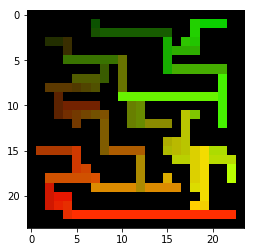

In [116]:
target_pos = np.zeros([sol.shape[0],sol.shape[1],3]) #only using 0 and 1
visited =  np.zeros([sol.shape[0],sol.shape[1]])
visited[maze_viz[:,:,2] > 0.5] = 1

print(sol[0,0,:])
def f(y,x):
    #print y,x
    return { # inverse
        up : (False,(y+1,x)),
        down : (False, (y-1,x)),
        left : (False, (y,x+1)),
        right : (False,(y,x-1)),
        (0,0,0) : (True,(y,x)),
    }[tuple(sol[y,x])]

for y in xrange(img.shape[0]):
    for x in xrange(img.shape[1]):
        if visited[y,x] == 0:
            queue = [(y,x)]
            val = sol[y,x]

            while True:
                yn,xn = queue[-1]
                #print f(yn,xn),queue
                end, new_pos = f(yn,xn)
                #print end,new_pos,queue
                if end:
                    break
                if (sol[new_pos[0],new_pos[1],:] != val).any():
                    break
                queue.append(new_pos)
            #print new_pos,queue
            for q in queue:
                target_pos[q[0],q[1],0] = new_pos[0]
                target_pos[q[0],q[1],1] = new_pos[1]
                visited[q[0],q[1]] = 1
vis_target =target_pos[:,:,:]/np.max(target_pos[:,:,:],(0,1))
plt.imshow(vis_target,interpolation='nearest')

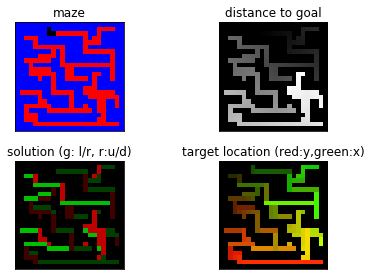

In [117]:
dist /= dist.max()
plt.subplot(2,2,1)
plt.imshow(maze_viz,interpolation='nearest')
plt.xticks([])
plt.title('maze')
plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(dist,interpolation='nearest')
plt.xticks([])
plt.title('distance to goal')
plt.yticks([])
plt.subplot(2,2,3)
plt.imshow(sol,interpolation='nearest')
plt.title('solution (g: l/r, r:u/d)')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,4)
plt.imshow(vis_target,interpolation='nearest')
plt.title('target location (red:y,green:x)')
plt.xticks([])
plt.yticks([])
plt.tight_layout()